In [3]:
from amalearn.reward import GaussianReward, RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import gym

* Reward class: 
    * The following Reward class inherits from RewardBase class and adds mean and variance of the reward distribution along with sum of all rewards recieved from this distribution and the number of times we got a sample of this reward. 
    * The Update method is used for agent defined rewards which needs to update the rewards mean and variance after each sample. 
* NArmedBanditEnvironment class:
    * The NArmedBanditEnvironment class adds the achieved regrets, percent of selecting the optimal action, number of arms (arm_count), the real rewards of the environment (real_rewards) and the guest reward features of the Thompson sampling agent (TS_rewards) to the EnvironmentBase class.
    * The sample_all_rewards method samples random from each action and returns the maximum's index
    * The calculate_reward metod gets a reward from selected action's reward.
    * The update_selected_arm method updates the selcted arm based on Thompson Sampling.
* Agent class:
    * The take_action method samples for all arm sample (theta), gets the action which has the max sample (At = max theta), recieves the reward of doing the selected action and updates the reward features based on the achieved reward.

In [11]:
class Reward(RewardBase):
    '''initializing the std, mean, recieved rewards and number of times this arm was selected'''
    def __init__(self, mean, var):
        super(Reward, self).__init__()
        self.m = mean
        self.var = var
        self.rewards_sum = 0
        self.rewards_count = 0
    
    '''get a sample from this reward'''
    def get_reward(self):
        return np.random.normal(loc=self.m, scale=sqrt(self.var))
    
    '''update:
            m(t+1) = (mt/var(t) + reward_sum) / (reward_count + 1/var(t))
            var(t+1) =  1/(1+1/var(t)) equal to add 1 to precision
    
    '''
    def update(self, Ri):
        self.rewards_sum = self.rewards_sum + Ri
        self.rewards_count = self.rewards_count + 1
        tau = 1/self.var
        self.m = (self.m * tau + self.rewards_sum)/ (self.rewards_count + tau)
        tau = tau + 1
        self.var = 1/tau

class NArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, real_reward_mean, real_reward_var, Ts_mean, Ts_var, arm_count, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(arm_count)
        super(NArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.regret = []
        self.arm_count = arm_count
        self.real_rewards = []
        self.Ts_rewards = []
        self.optimal_selection = []
        self.optimal_action = np.argmax(real_reward_mean)
        for i in range(arm_count):
            self.real_rewards.append(Reward(real_reward_mean[i],real_reward_var[i]))
            self.Ts_rewards.append(Reward(Ts_mean,Ts_var))

    def sample_all_rewards(self):
        sample = [self.Ts_rewards[i].get_reward() for i in range(self.arm_count)]
        return np.argmax(sample)
    
    def update_selected_arm(self, index, Ri):
        self.Ts_rewards[index].update(Ri)
    
    def calculate_reward(self, action):
        return self.real_rewards[action].get_reward()

    def terminated(self):
        return 

    def observe(self):
        return 

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        return

    def reset(self):
        return

    def render(self, mode='human'):
        #print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))
        return 

    def close(self):
        return
    
class Agent(AgentBase):
    def __init__(self, id, environment):
        super(Agent, self).__init__(id, environment)
    def take_action(self, cnt) -> (object, float, bool, object):
        #for all arm sample = theta
        #get At = max theta
        index_selected_arm = self.environment.sample_all_rewards()
        self.environment.optimal_selection.append(self.environment.Ts_rewards[self.environment.optimal_action].rewards_count)
        self.environment.regret.append(self.environment.real_rewards[self.environment.optimal_action].m * cnt - np.sum([self.environment.Ts_rewards[i].rewards_sum for i in range(self.environment.arm_count)]))
        #Do At get Rt
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #update mt m(t+1) = (mt/std(t) + reward_sum) / (reward_count + 1/std(t))
        #update stdt std(t+1) = 1/(1+1/std(t)) equal to add 1 to precision
        self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

The following start_trials method recieves the number of trials needed and calls the take_action method of the agent and calculates the regret and return percent of optimal action selection. In addition, for every trial in the plot_trial, this method plots the guesed reward distribution of the action.

In [21]:
def start_trials(env, trial_cnt, agent, plot_trial):
    for i in range(trial_cnt+1):
        agent.take_action(i+1)
        if i in plot_trial:
            print("Trial:" + str(i))
            for j in range(env.arm_count):
                mu = env.Ts_rewards[j].m
                variance = env.Ts_rewards[j].var
                sigma = sqrt(variance)
                x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
                plt.plot(x, stats.norm.pdf(x, mu, sigma), label= 'action'+str(j+1))
            plt.xlabel("Reward")
            plt.ylabel("Density")
            plt.legend()
            plt.show()
    return [env.optimal_selection[i]/(i+1) for i in range(trial_cnt+1)]

Plotting the rewards distribution for the 1, 30, 70, 300, 700 and 1000th trial of the first run.

Trial:30


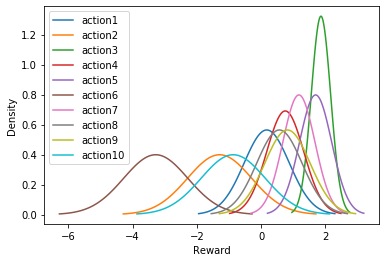

Trial:70


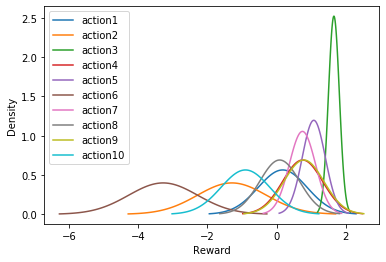

Trial:300


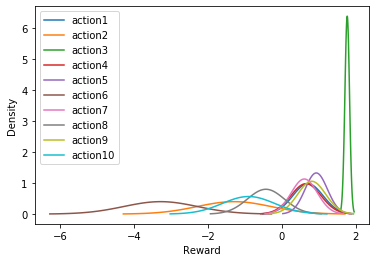

Trial:700


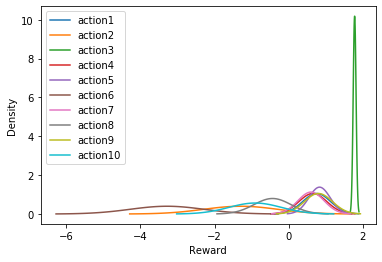

Trial:1000


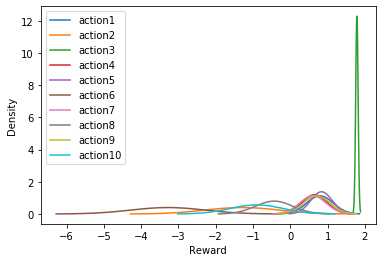

In [26]:
reward_means = [0.2,-0.8,1.8,0.3,1.1,-1.3,-0.1,-1,0.8,-0.4]
reward_var = [1,1,1,1,1,1,1,1,1,1]
oprimal_percent = []
regret = []
env = NArmedBanditEnvironment(reward_means, reward_var, 0, 1000, 10, 1)
agent = Agent('1', env)
oprimal_percent.append(start_trials(env, 1000, agent, [30, 70, 300, 700, 1000]))
regret.append(env.regret)

Plotting the Regret and % of selecing the oprimal action through all Trials.

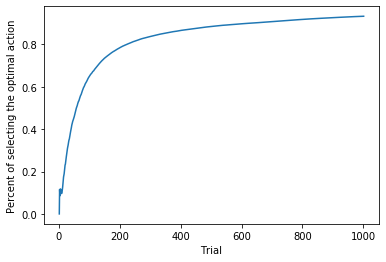

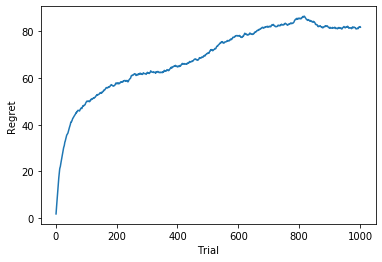

In [24]:
for i in range(19):
    env = NArmedBanditEnvironment(reward_means, reward_var, 0, 1000, 10, 1)
    agent = Agent('1', env)
    oprimal_percent.append(start_trials(env, 1000, agent, []))
    regret.append(env.regret)
plt.xlabel("Trial")
plt.plot([i+1 for i in range(1001)], np.mean(oprimal_percent, axis=0))
plt.ylabel("Percent of selecting the optimal action")
plt.show()
plt.plot([i+1 for i in range(1001)], np.mean(regret, axis=0))
plt.ylabel("Regret")
plt.xlabel("Trial")
plt.show()